Fabián Ontiveros Juárez 173428
# Genetic Algorithms

In this notebook, I present a solution to the problem of minimum path search on a graph using a Genetic Algorithm.


In [159]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import PIL
import matplotlib.collections as mc
import matplotlib.animation as animation
from scipy.sparse import csr_matrix
from time import time
from scipy.stats import norm
from itertools import accumulate, starmap, repeat
import operator
import imageio.v3 as iio

In [ ]:
! mkdir "frames"

mkdir: cannot create directory ‘frames’: File exists


# The metro system problem

We will solve the minimum path search problem in the context of the CDMX metro system. In the first place, let's create a representation of the metro system with a graph $G=(V,E)$.

In [ ]:
map_image = plt.imread("plano-red-metro-cdmx.jpg")
nodes_image = plt.imread("Nodos-metro.jpg")

```map_image``` is the original reference image of the CDMX metro system and ```nodes_image``` is a self-created image in Power Point with black circles overlayed in the position of the relevant metro stations (the ones with names and a white circle with a black contour).

In [ ]:
x,y = np.meshgrid(np.arange(nodes_image.shape[1]),np.arange(nodes_image.shape[0]))
x = x.reshape(-1,1)*(map_image.shape[1]/nodes_image.shape[1])
y = y.reshape(-1,1)*(map_image.shape[0]/nodes_image.shape[0])

nodes_data_matrix = np.block([x,y,nodes_image[:,:,0].reshape(-1,1)])
nodes_data_matrix = nodes_data_matrix[nodes_data_matrix[:,2] < 10][:,:2]

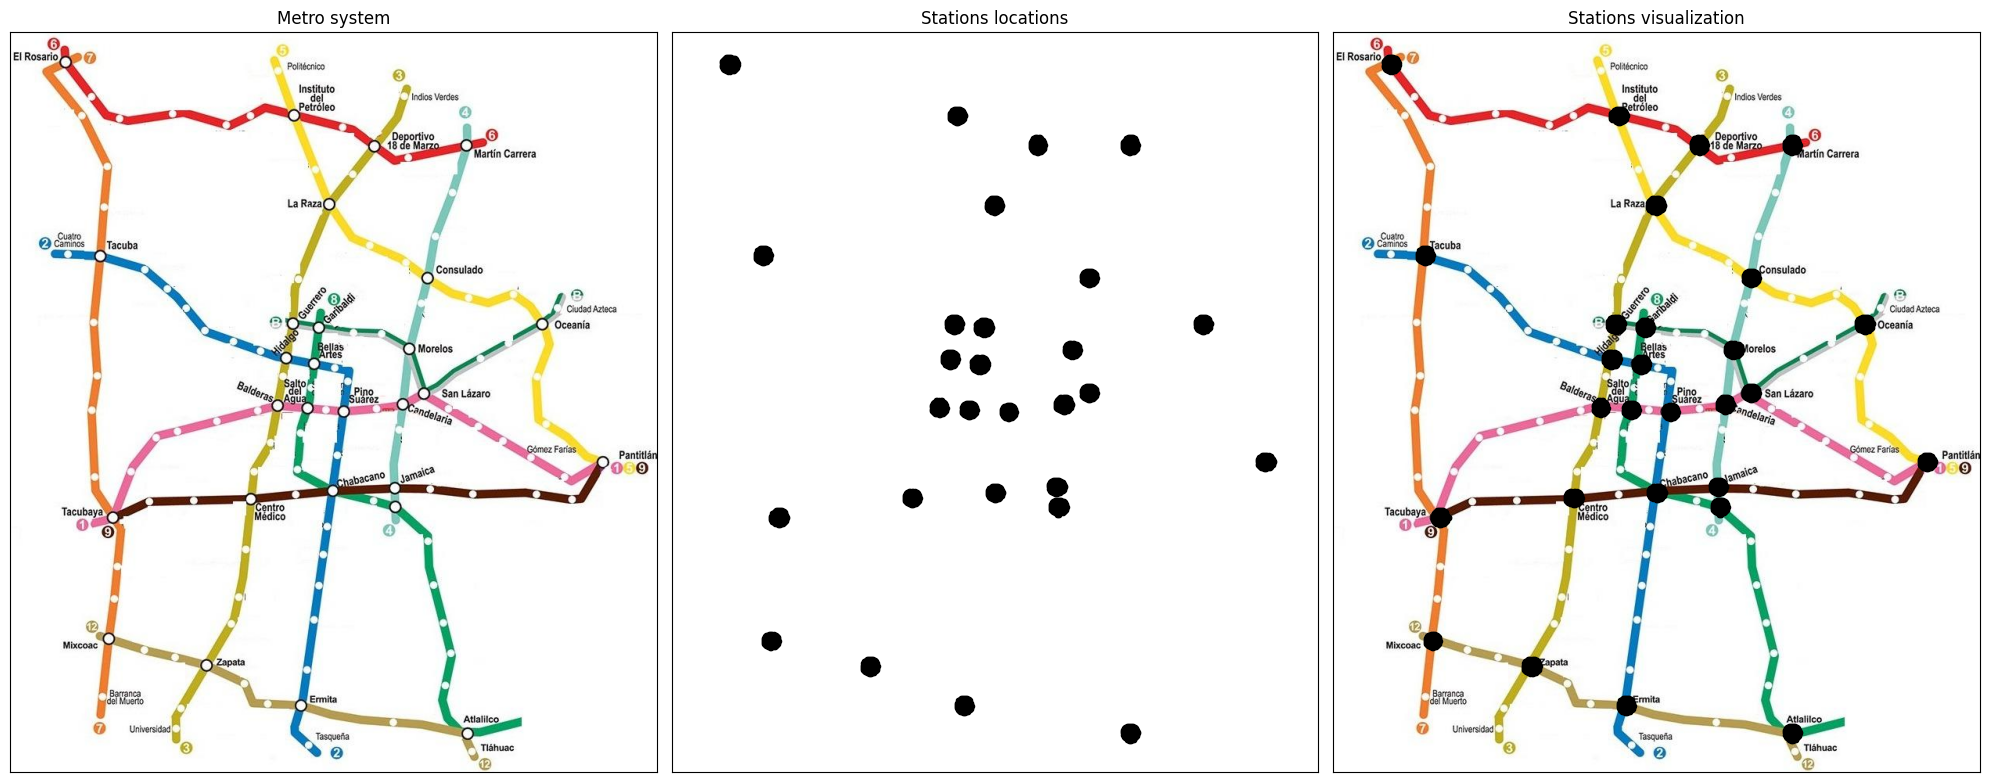

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(20,50))
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].imshow(map_image)
ax[0].set_title("Metro system")

ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].imshow(np.ones_like(map_image)*255)
ax[1].scatter(nodes_data_matrix[:,0],nodes_data_matrix[:,1],color="black",marker=".")
ax[1].set_title("Stations locations")

ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].imshow(map_image)
ax[2].scatter(nodes_data_matrix[:,0],nodes_data_matrix[:,1],color="black",marker=".")
ax[2].set_title("Stations visualization")
plt.tight_layout()
plt.show()

To make a good visualization of the results, we will perform the KMeans algorithm for K=28 on the black circles dataset from the image before in order to determine their center and get a 2-tuple $(x,y)\in\mathbb{R}^2$ representation of poits which will be used furhter for the visualization part.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=28,n_init=10,random_state=31416).fit(nodes_data_matrix)
centers = kmeans.cluster_centers_
centers = centers[np.argsort(centers[:,1]*(centers[:,0].max())+centers[:,1])]

## Graph representation

After this, lets manually build the **adjacency matrix** $A$ for the graph $G$ based on the metro system image. Such graph will be a weighted one such that the weight $w_{ij}$ has values according to

$$w_{ij} =  0, \text{if}\ \{v_i,v_j\}\notin E$$
$$w_{ij} = \#\{\mathrm{stops\ from}\ v_i\ \rightarrow v_j \}, \text{if}\ \{v_i,v_j\}\in E$$

In [ ]:
row = np.array([0,1,2,2,3,0,5,23,24,25,26,6,7,4,5,8,8,9,11,9,6,7,10,14,1,4,10,11,15,12,16,12,17,15,23,15,16,21,17,20,14,13,19,19,20,25,20,22])
col = np.array([1,2,3,4,6,5,23,24,25,26,27,7,18,8,11,11,9,12,12,10,10,13,13,13,4,6,14,15,16,16,17,17,14,23,21,21,20,20,20,19,19,18,18,22,22,21,26,27])

weights = np.array([6,2,2,2,3,4,5,3,3,3,  2,3,3,2,7,1,1,1,1,3,  2,3,1,1,2,3,1,2,1,2,   2,3,2,6,3,3,3,2,2,1,  2,6,5,1,2,4,6,6])

adj = csr_matrix((np.concatenate([weights,weights]), (np.block([row,col]), np.block([col,row]))), shape=(28,28)).toarray()

See a graphical visualization of $A$.

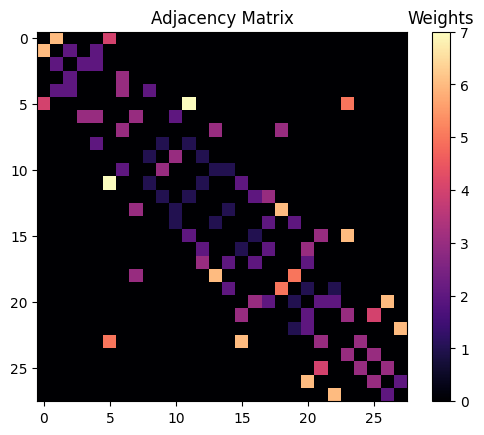

In [ ]:
fig,ax = plt.subplots()
cbar = plt.colorbar(plt.imshow(adj,cmap="magma"))
cbar.ax.set_title("Weights")
ax.imshow(adj,cmap="magma")
ax.set_title("Adjacency Matrix")
plt.show()

## Graph visualization

Now, we are able to build the graph $G$ with the cluster centers and the adjacency matrix. If $C_1,\dots,C_{K}$ are the 28 cluster centers, we draw the line segment $l_{ij}(t) = C_jt + (1-t)C_i$ for $t\in[0,1]$ if $A_{ij}\neq0$ which will represent the edge $\{v_i,v_j\}$.

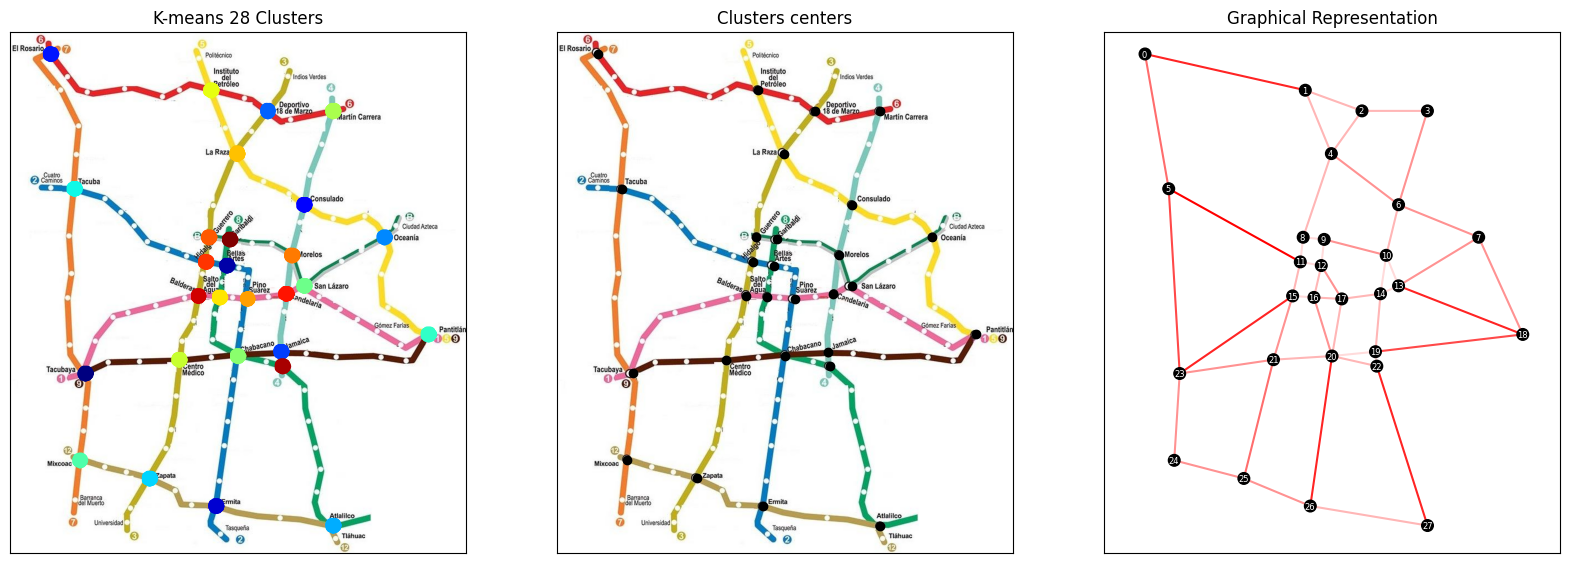

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(20,50))
ax[0].imshow(map_image)
ax[0].scatter(nodes_data_matrix[:,0],nodes_data_matrix[:,1],c=kmeans.labels_,marker=".",cmap="jet")
ax[0].set_title("K-means 28 Clusters")

ax[1].imshow(map_image)
ax[1].scatter(centers[:,0],centers[:,1],marker="o",color="black")
ax[1].set_title("Clusters centers")

ax[2].imshow(np.ones_like(map_image)*255)

for i in range(len(row)):
  ax[2].plot(centers[[row[i],col[i]]][:,0],centers[[row[i],col[i]]][:,1],color="red",alpha=weights[i]/weights.max(),zorder=1)

ax[2].scatter(centers[:,0],centers[:,1],marker="o",color="black",zorder=2,s=70*np.ones(28))

for i in range(28):
  ax[2].text(centers[i,0]-(10 if len(str(i)) == 2 else 6),centers[i,1]+5,str(i),color="white",fontsize=6,zorder=3)
ax[2].set_title("Graphical Representation")

for i in range(3):
  ax[i].set_xticks([])
  ax[i].set_yticks([])
plt.show()

Let $\tilde{A}\in\mathbb{R}^{28\times28}$ such that



 $$\tilde{A}_{ij}=0, \text{if} A_{ij} = 0$$
 $$\tilde{A}_{ij} = 1 \text{if} A_{ij} \neq 0$$
  


 If $n\in\mathbb{N}$, a well known result in graph theory is that $(\tilde{A}^n)_{ij}$ quantifies the number of simple paths between $v_i$ and $v_j$ in $n$ steps. Then, we are interested in determining the least $n$ such that $(\tilde{A}^n)_{ij}\neq 0$ for some specific $i,j$.

In [ ]:
for k in range(1,10):
  if np.linalg.matrix_power(1*(adj != 0),k)[0,13] != 0:
    print(k)
    break

5


Such information will be helpful to determine the minimum size of a genome in our implementetion, but more on that later.

Finally, we create several functions to visualize $G$ and a path from $v_i$ to $v_j$ in a fancy animated manner.

In [ ]:
def generate_figure():
  global centers
  fig,ax = plt.subplots(figsize=(7*map_image.shape[1]/map_image.shape[0],7))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.scatter(centers[:,0],centers[:,1],marker="o",color="black",zorder=2,s=75*np.ones(28))
  for i in range(28):
    ax.text(centers[i,0]-(9 if len(str(i)) == 2 else 5),centers[i,1]+5.5,str(i),color="white",fontsize=6,zorder=2)
  ax.invert_yaxis()
  return fig,ax

def plot_path(path,ax):
  global centers
  for i in range(len(path)-1):
    ax.plot(centers[[path[i],path[i+1]]][:,0],centers[[path[i],path[i+1]]][:,1],color=("red" if adj[path[i],path[i+1]]!=0 else "blue"),alpha=1,zorder=1)

def plot_segment(path,k,ax):
  global centers
  i = path[max([0,k-1])]
  j = path[k]
  start = centers[i]
  end = centers[j]
  ax.plot([start[0],end[0]],[start[1],end[1]],color=("red" if adj[i,j]!=0 else "blue"),alpha=1,zorder=1)

def update(frame,path,ax):
  plot_segment(path,frame,ax)
  return (ax)

def animate(path):
  fig, ax = generate_figure()
  ani = animation.FuncAnimation(fig=fig, func=update, frames=len(path), interval=100, fargs=(path,ax))
  return fig,ax,ani

# The Genetic Algorithm

Let $v_1, v_2 \in V$ such that $P: v_1 = v^1 \rightarrow \cdots \rightarrow v^n = v_2$ is a simple path between $v_1$ and $v_2$. We define the distance of the path $P$ as follows:
$$d(P) = \sum_{j=1}^n w(v^j, v^{j+1})$$

where $w(v^j, v^{j+1})$ represnts the weight from the edge $\{v^j, v^{j+1}\}\in E$.

With this, we define the **fitness function** $f$ of $P$ as
$$f(P) = \frac{1}{d(P)}$$

In our context, any simple path $P$ from "El Rosario" ($v_0$) to "San Lázaro" ($v_{13}$) will be considered a **genome**.

In [ ]:
def distance(path):
  global adj
  return sum(adj[path[i],path[i+1]] for i in range(len(path)-1))

def fitness(path):
  return 1/distance(path)

Now, let's define a procedure to generate a **random simple path** between two nodes $a,b\in V$ with the help of $A$.

In [ ]:
def generate_path(start,end,visited_start=[],its=0):
  global adj
  visited = visited_start.copy()
  j = start
  while j != end:
    visited.append(j)
    i = j
    options = list(set(np.where(adj[i] != 0)[0]).difference(set(visited)))
    if len(options) == 0:
      its += 1
      if its < 20:
        return generate_path(start,end,visited_start,its=its)  # restart if the path has reached a dead-end
      else:
        return generate_path(0,13)     # if maximum recursivity is reached
    j = np.random.choice(options)
  visited.append(end)
  return visited

With this, we now may define some other functions as part of the genetic approach:


*   A generator of a random sample of genomes
*   A selection procedure (we will use the ranking method)
*   A breeding procedure
*   A mutation procedure



In [ ]:
def first_generation(start,end,max_paths):
  paths = list(starmap(generate_path,repeat((start,end),max_paths)))
  return paths

def selection(paths):
  fit = np.array(list(map(fitness,paths)))
  ranked = np.argsort(fit)[::-1].tolist()
  cumsum = fit[ranked].cumsum()
  prob = cumsum / cumsum[-1]
  selected = ranked[:elite_size] + list(map(lambda x: np.argmax(x <= prob), np.random.random(len(ranked)-elite_size)))
  return selected

The hardest part in this activity is to ensure that modifications of the current genomes leave a new **valid** genome. In this cell, I explain and implement an algorithm that ensures returning one (valid) child after breeding two parents.

Let $P_1:a=v^1\rightarrow\cdots→ v^n=b$ and $P_2:a=u^1\rightarrow\cdots→ u^m=b$ be two simple paths from $a$ to $b$. To breed $P_1$ and $P_2$ we will procede as follows

**Case 1**

Suppose that $P_1\cap P_2\neq\emptyset$ then, $\forall\ \mu\in P_1\cap P_2$, $\exists\  v^i\in P_1,u^j\in P_2$ such that $\mu=v^i=u^j$.

If $v^1\rightarrow\cdots\rightarrow v^{i-1}\cap u^{j+1}\rightarrow\cdots\rightarrow u^{m}\neq\emptyset$ we **breed** $P_1$ and $P_2$ to create a new simple path $P_3$ given by
$$P(\mu):v^1\rightarrow\cdots\rightarrow v^{i-1}\rightarrow \mu →v^{j+1}\rightarrow\cdots\rightarrow u^{m}$$
which is a valid genome because none of the vertices at the right appears at the left and it starts and ends at the same places.

If the former is not true, we skip such $\mu$ and pass to the next one (if exists).

Suppose that this process is valid for some $\mu_1,\dots\mu_k\in P_1\cap P_2$, so we form childs $P(\mu_1),\dots,P(\mu_k)$. Now, in the sake of omptimality, we return the path $P(\mu_s)$ that maximices the fitness function value.

**Case 2**

Suppose that $P_1\cap P_2=\emptyset$ or Case 1 is false for all $\mu\in P_1\cap P_2$ then we say that $P_1$ and $P_2$ are **not breedable** and simply return one of both at random.

In [ ]:
def breed(i,j,paths):
  parent1 = paths[i]
  parent2 = paths[j]
  common = list(set(parent1[1:-2]).intersection(set(parent2[1:-2])))
  if len(common)==0:
    return [parent1,parent2][np.argmax([fitness(parent1),fitness(parent2)])]
  options = []
  value = []
  for k in common:
    i = np.where(np.array(parent1) == k)[0][0]
    j = np.where(np.array(parent2) == k)[0][0]
    if len(set(parent1[i:-2]).intersection(set(parent2[j+1:-2])))==0:
        child = parent1[:i] + parent2[j:]
        options.append(child)
        value.append(fitness(child))
  if len(value) != 0:
    return options[np.argmax(value)]
  else:
    return random.choice([parent1,parent2])

def breedPopulation(mating_pool, paths, elite_size):
  pool = random.sample(mating_pool, len(mating_pool))
  length = len(mating_pool) - elite_size
  children = [paths[x] for x in mating_pool[:elite_size]] + list(map(breed, pool[:length], pool[:length][::-1], repeat(paths,length)))
  return children

Now, we implement a mutation process as follows.

Let $P:a=v^1→⋯→v^n=b$ be a simple path from $a$ to $b$. Now, with probability $p$ select some random vertex $v^i\in P-\{a,b\}$ and define $P^{(i)} = v^1→⋯→ v^{i-1}\subset P$ as the $i$-th cut of $P$. Now, we run the ```generate_path``` procedure with parameters $v^i,v^n,P^{(i)}$ and return the result.

Note that there exists at least one path that connects $v^i$ to $b$ without passing by the former nodes, which is $v^{i}\rightarrow\cdots\rightarrow v^{n}$ itself. Hence, this process will always return a valid genome.

In [ ]:
def mutate(path, mutation_rate):
  if np.random.random() < mutation_rate:
    i = np.random.choice(range(1,len(path)-1))
    return generate_path(path[i],path[-1],path[:i])
  else:
    return path

def mutate_population(paths, mutation_rate, elite_size):
  mutated_population = list(map(mutate, paths[:elite_size]+paths.copy(), repeat(mutation_rate,len(paths)+elite_size))) # the ...paths.copy()... is used to ensure monotonicity.
  return mutated_population

def next_generation(paths, elite_size, mutation_rate):
  selected = selection(paths)
  children = breedPopulation(selected,paths,elite_size)
  new_paths = mutate_population(children,mutation_rate,elite_size)
  return new_paths

# Execution

Recall that the idea of genetic algorithms is to avoid computing all combinations to detemine the optimum one. Hence, as the graph in our problem is "small" let's create a small initial population of just 3 genomes and run the process for 100 iterations.

I fixed the ```elite_size``` and ```mutation_rate``` to be 2 and 0.5 because this worked enough for me, but feel free to modify them and see what happens.

In [ ]:
max_paths = 3
elite_size = 2
mutation_rate = 0.5
iterations = 100

paths = first_generation(0,13,max_paths)
history = [paths[0]]
total_paths = 0

for i in range(iterations):
  selected = selection(paths)
  children = breedPopulation(selected,paths,elite_size)
  history.append(paths[selected[0]])
  paths = mutate_population(children, mutation_rate, elite_size)
  total_paths += len(paths)

best_selected = selection(paths)
history.append(paths[best_selected[0]])

Run the following cell to display a graph of the fitness value of the best genome (the one with maximum fitness value) at each iteration, until reaching its maximum achieved value trhough all iterations.

I included a horizontal line with the global optimum fitness value, which corresponds to the path $0\rightarrow1\rightarrow4\rightarrow6\rightarrow10\rightarrow13$.

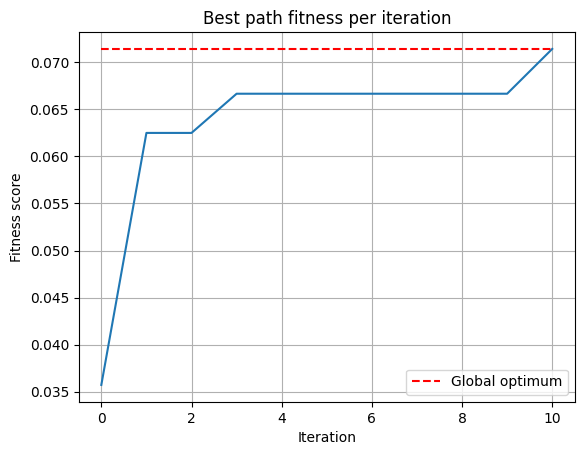

In [130]:
values = np.array([fitness(path) for path in history])
k = np.argmax(values == values.max()) + 1

fig,ax = plt.subplots()
ax.plot(np.arange(k),values[:k],color="tab:blue")
ax.plot(np.arange(k),np.ones(k)*fitness([0,1,4,6,10,13]),
        color="red",linestyle="--",label="Global optimum")
ax.set_title("Best path fitness per iteration")
ax.set_xlabel("Iteration")
ax.set_ylabel("Fitness score")
ax.legend()
ax.grid()
plt.show()

Similarly, run the following cell to create an animation of the beest path at each iteration in the graph, where you can see how mutations and breeding at each modifies the current best path until reaching the maximum high fitness value though all iterations.

**Note:** If the ```its``` value is large enough, global optimum finding is insured just by chance alone in the mutation process.

In [131]:
for i,path in enumerate(history[:k]):
  fig,ax,ani = animate(path)
  ax.set_title(f"Iteration {i}")
  ani.save(f"frames/animation{i}.gif")
  plt.close()

frames = np.vstack([iio.imread(f"frames/animation{i}.gif") for i in range(k)])
duration = iio.immeta("frames/animation0.gif")["duration"]

iio.imwrite("animation.gif", frames, duration=duration)

Finally, to study the general model performance, we will generate 250 populations and run the genetic algorithm for 20 iterations. With the data recovered we form the following figure, where I show the mean of the $i$-th iteration and a $99%$ Confidence Interval for the mean.

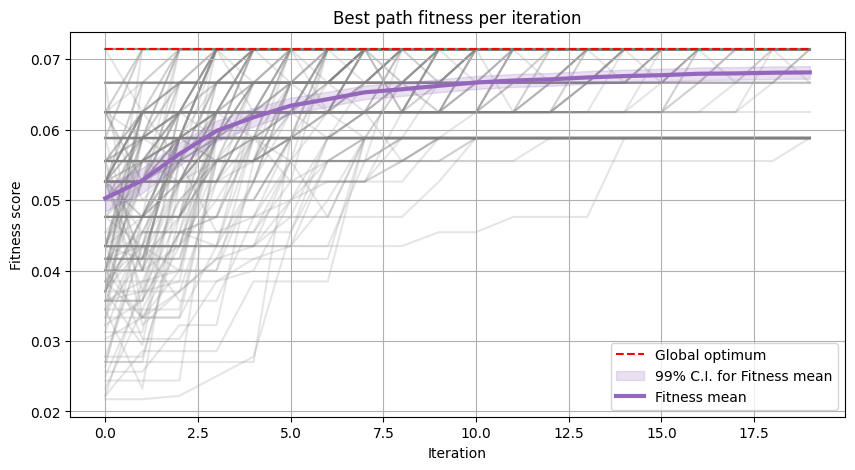

In [191]:
max_paths = 3
elite_size = 2
mutation_rate = 0.5
iterations = 20
iterations_2 = 250

history = np.zeros((iterations_2,iterations))

for i in range(iterations_2):
  paths = first_generation(0,13,max_paths)
  for j in range(iterations):
    selected = selection(paths)
    children = breedPopulation(selected,paths,elite_size)
    history[i,j] = fitness(paths[selected[0]])
    paths = mutate_population(children, mutation_rate, elite_size)

moe = np.abs(norm(0,1).ppf(0.01/2)*history.std(axis=0)/iterations_2**.5)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(np.arange(iterations),np.ones(iterations)*fitness([0,1,4,6,10,13]),
        color="red",linestyle="--",label="Global optimum",zorder=3)
for i in range(iterations_2):
  ax.plot(np.arange(iterations),history[i],alpha=0.2,color="gray",zorder=1)
ax.fill_between(np.arange(iterations),history.mean(axis=0)-moe,history.mean(axis=0)+moe,alpha=0.2,color="tab:purple",zorder=2,label="99% C.I. for Fitness mean")
ax.plot(np.arange(iterations),history.mean(axis=0),alpha=1,color="tab:purple",zorder=2,linewidth=3, label="Fitness mean")
ax.set_title("Best path fitness per iteration")
ax.set_xlabel("Iteration")
ax.set_ylabel("Fitness score")
ax.legend()
ax.grid()
plt.show()

In [205]:
target = 0.9
idx = np.where((fitness([0,1,4,6,10,13]) - (history.mean(axis=0) - moe)) / fitness([0,1,4,6,10,13]) <= 1-target)[0][0]
print(f"The mean fitness value above the {idx-1}-th iteration is closer than or as good as {round(100*target,2)}% from the value achieved by the global optimum")

The mean fitness value above the 6-th iteration is closer than or as good as 90.0% from the value achieved by the global optimum
